In [1]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [122]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())
library(gapminder)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



### Review

In [186]:
load('review.RData')
print(review_dfs)

# A tibble: 3 x 2
  dataset data              
    <dbl> <list>            
1       1 <tibble [100 × 2]>
2       2 <tibble [100 × 2]>
3       3 <tibble [100 × 2]>


For each of these three nested data sets, use linear regression to find an appropriate model relating $x$ and $y$.

In [194]:
# Your code here

# Lecture 22: More on regression and classification

In [12]:
by_country = gapminder %>% group_by(country, continent) %>% nest
f <- function(df) lm(lifeExp ~ year, data = df)
gl <- mutate(by_country, model = map(data, f),
             glance = map(model, broom::glance)) %>% 
             unnest(glance)
bad_fit = filter(gl, r.squared < 0.25)

Last lecture we saw that some countries in Africa experienced a sharp drop in life expectancy in the 1990s:

Joining, by = c("country", "continent")


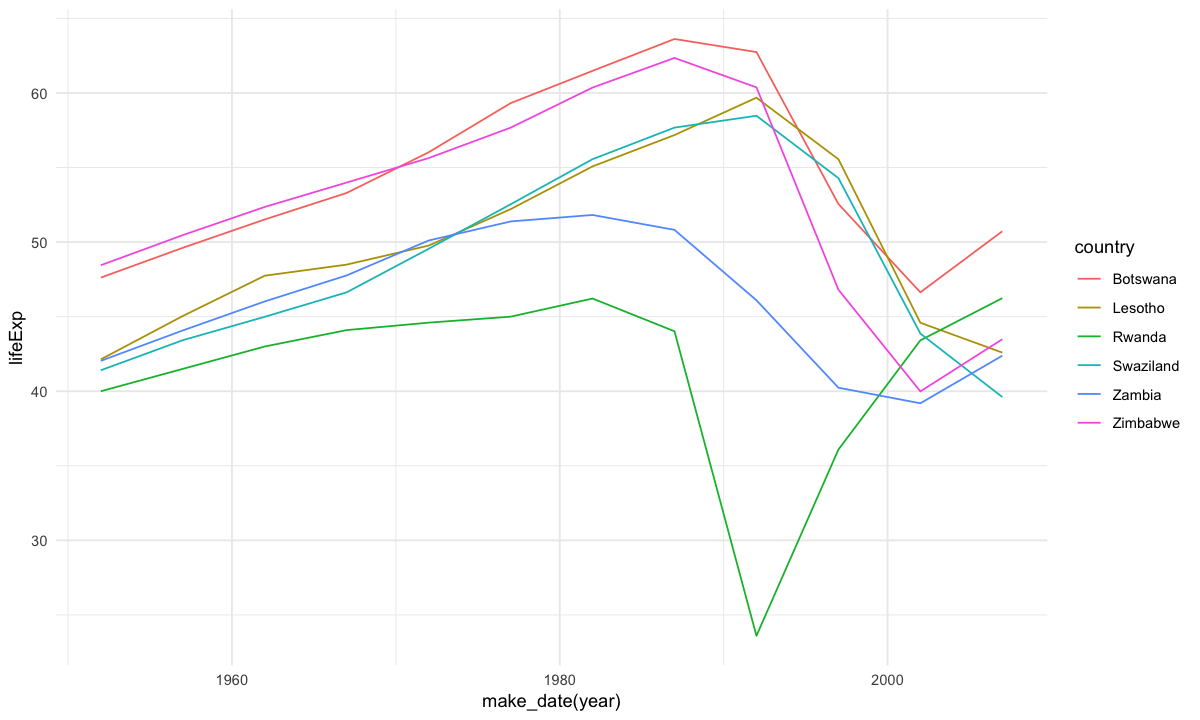

In [5]:
gapminder %>% semi_join(bad_fit) %>% 
    ggplot(aes(make_date(year), lifeExp, color = country)) +
    geom_line()

What is an appropriate model for this data? Clearly a line is not sufficient. We might think about fitting *two* lines per population.
### Exercise
Use the linear model to fit a "two-period" growth model to each of these countries: each country gets one slope and intercept for 1950-1990, and gets another slope and intercept for 1990-present.

In [196]:
# Your code here

Another option for fitting these data is no use a non-linear model:

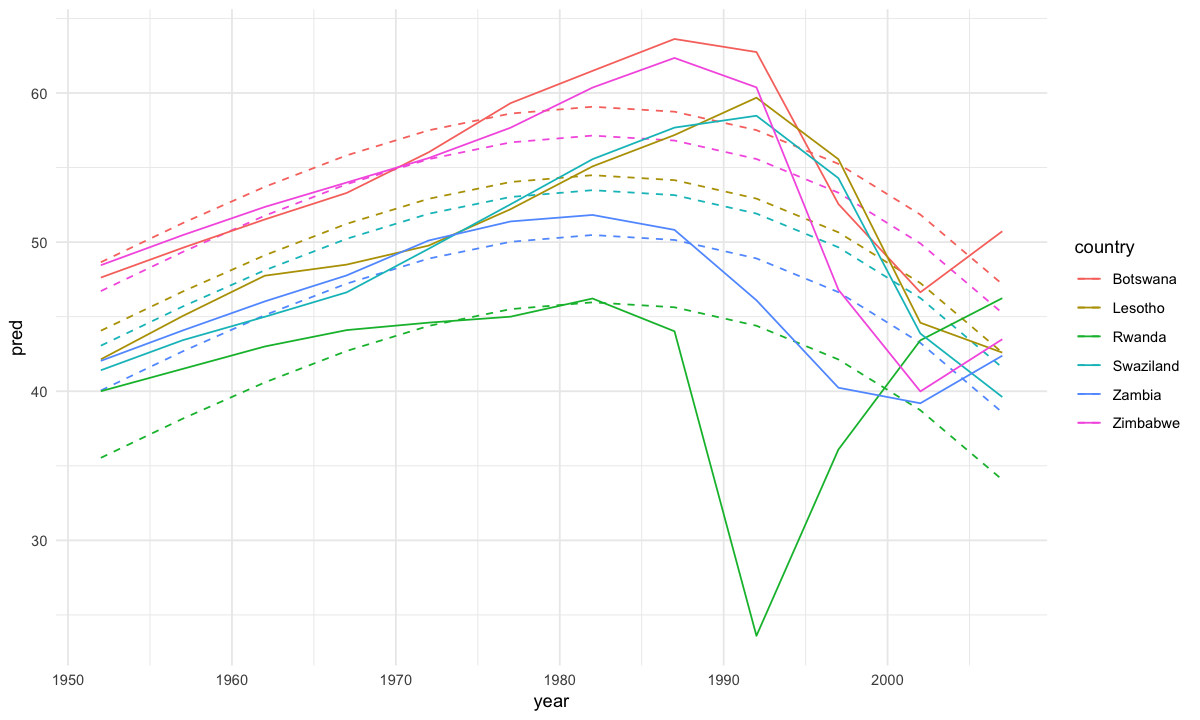

In [38]:
mdl <- lm(lifeExp ~ country + poly(year, 3), data=df)
df %>% add_predictions(mdl) %>% ggplot(aes(x=year, colour=country)) + 
    geom_line(aes(y=pred), linetype="dashed") + geom_line(aes(y=lifeExp))

The function `poly(year, 3)` indicates that we have added a third-order polynomial, so that our linear model is now

$$\text{lifeExp} = \text{<country intercept>} + a_1 \text{year} + a_2 \text{year}^2 + a_3 \text{year}^3.$$

(Notice that this model is still linear in $a_i$.)

One downside of this type of approach is interpretability:

In [39]:
summary(mdl)


Call:
lm(formula = lifeExp ~ country + poly(year, 3), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.7933  -2.2033   0.2382   2.4074  12.1768 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        54.598      1.341  40.723  < 2e-16 ***
countryLesotho     -4.590      1.896  -2.421  0.01837 *  
countryRwanda     -13.116      1.896  -6.918 2.78e-09 ***
countrySwaziland   -5.595      1.896  -2.951  0.00444 ** 
countryZambia      -8.601      1.896  -4.536 2.63e-05 ***
countryZimbabwe    -1.934      1.896  -1.020  0.31154    
poly(year, 3)1      1.270      4.644   0.273  0.78539    
poly(year, 3)2    -32.616      4.644  -7.023 1.82e-09 ***
poly(year, 3)3     -5.181      4.644  -1.116  0.26886    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.644 on 63 degrees of freedom
Multiple R-squared:  0.6411,	Adjusted R-squared:  0.5956 
F-statistic: 14.07 on 8 and 63 DF,  p-value: 1.659e-1

## Drops in life expectancy
Which countries experienced the sharpest five-year drops in life expectancy? Can we explain why these occurred?

In [24]:
dlife = gapminder %>% arrange(country, year) %>% group_by(country) %>% 
                      mutate(dlife = c(NA, diff(lifeExp))) %>% arrange(dlife) %>% 
                      mutate(cy = str_c(country, ", ", year)) %>% ungroup
mdlife = mean(dlife$dlife, na.rm = T)

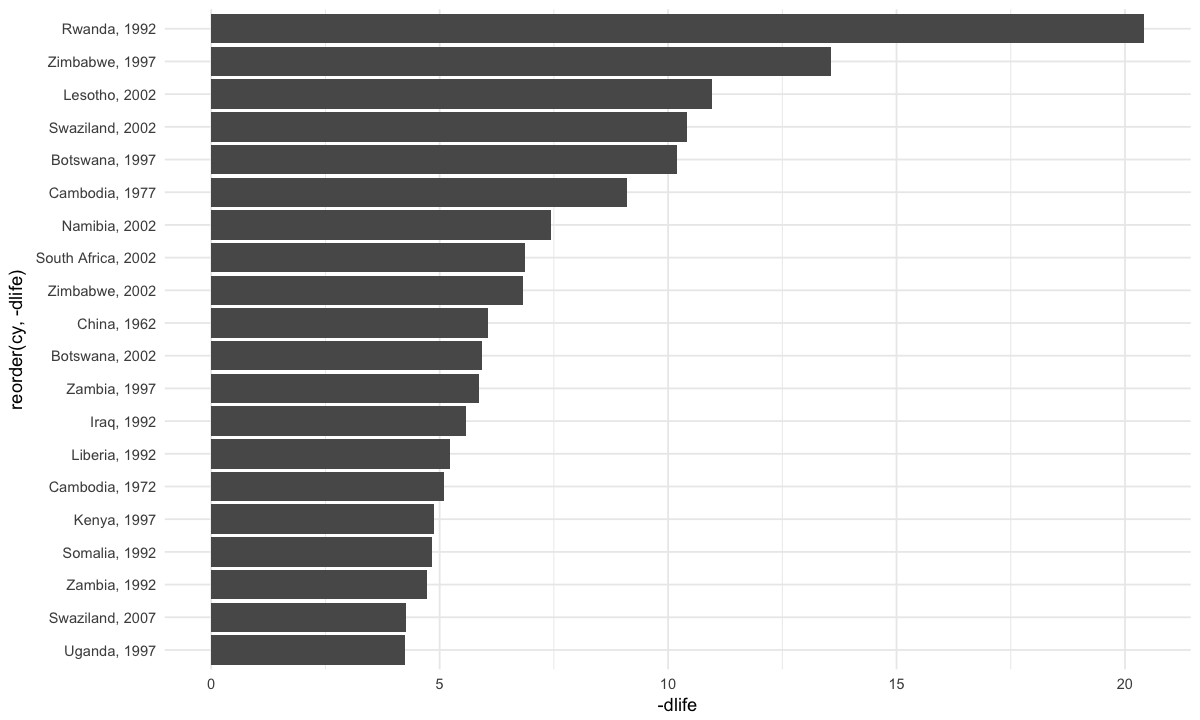

In [25]:
dlife %>% top_n(20, -dlife) %>% ggplot(aes(x = reorder(cy, -dlife), y = -dlife)) + geom_col() + coord_flip()

In most cases these drops in life expectancy appear to be due to the HIV/AIDS epidemic that ravaged sub-Saharan Africa in the late 1990s. To investigate this phenomenon further we will look at an [additional Gapminder data source](https://www.gapminder.org/data/) on the HIV infection rates.

## Reading Microsoft Excel files
The particular data we are interested in come are distributed as a Microsoft Excel spreadsheet. A lot of socio-economic data are distributed in this way, so this gives us a good chance to practice importing Excel data into R. 

<small>(This is probably the only time I will ever say something to the effect of "luckily, the data are in Excel format".)</small>

`tidyverse` conveniently gives us a `readxl` library for importing Excel data into R:

In [112]:
library(readxl)
hiv = readxl::read_xlsx("indicator hiv estimated prevalence% 15-49.xlsx") %>% print

# A tibble: 275 x 34
   `Estimated HIV Preval… `1979.0` `1980.0` `1981.0` `1982.0` `1983.0` `1984.0`
   <chr>                     <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>
 1 Abkhazia                NA            NA       NA       NA       NA       NA
 2 Afghanistan             NA            NA       NA       NA       NA       NA
 3 Akrotiri and Dhekelia   NA            NA       NA       NA       NA       NA
 4 Albania                 NA            NA       NA       NA       NA       NA
 5 Algeria                 NA            NA       NA       NA       NA       NA
 6 American Samoa          NA            NA       NA       NA       NA       NA
 7 Andorra                 NA            NA       NA       NA       NA       NA
 8 Angola                   0.0265       NA       NA       NA       NA       NA
 9 Anguilla                NA            NA       NA       NA       NA       NA
10 Antigua and Barbuda     NA            NA       NA       NA       NA       NA
# ... with 265 more

### Exercise
These data are untidy. `gather` them into a tidy format suitable for analysis.

To gain further insight, we can join the HIV data to our other gapminder data. Let us study further the relationship between HIV rate and life expectancy.

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”Warning message:
“Removed 1222 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1222 rows containing missing values (geom_point).”

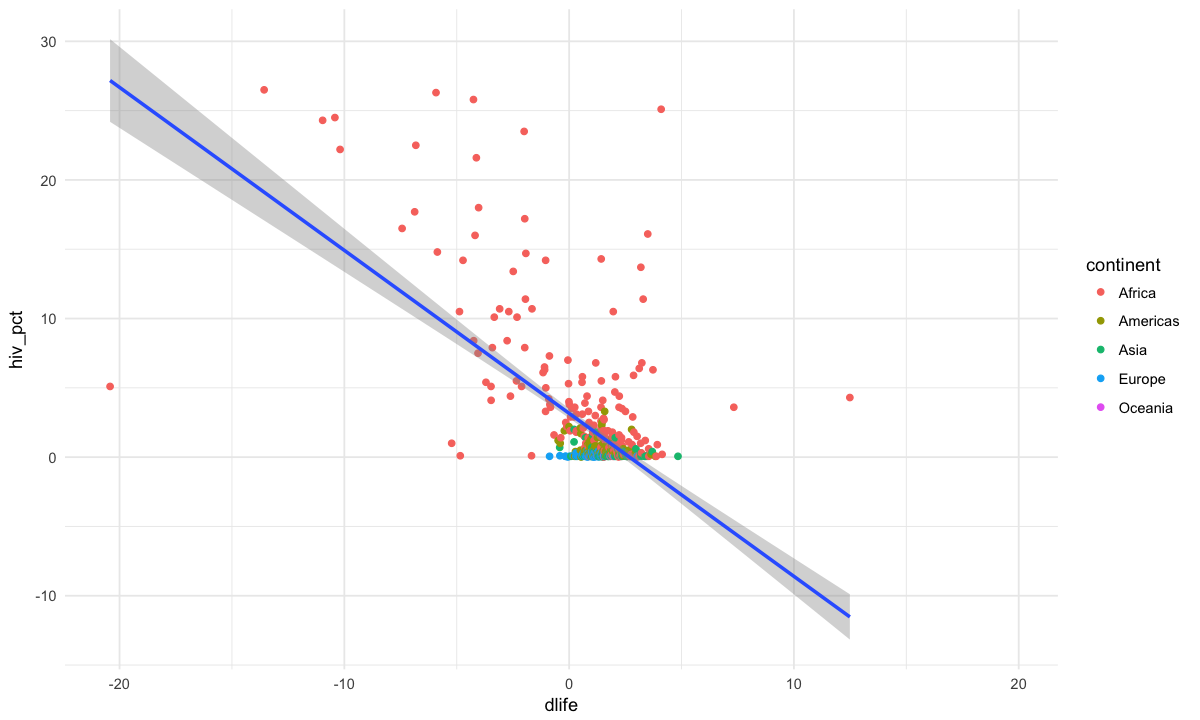

In [118]:
hiv_dlife = dlife %>% ungroup %>% mutate(year = make_date(year), dlife) %>%
    left_join(hiv)
ggplot(hiv_dlife, aes(dlife, hiv_pct)) + geom_point(aes(color = continent)) + 
    geom_smooth(method="lm")

Let us try and quantify this relationship using a linear model:

In [120]:
hiv_gap = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv)
mod = lm(lifeExp ~ hiv_pct , hiv_gap)
mod %>% summary

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


Call:
lm(formula = lifeExp ~ hiv_pct, data = hiv_gap)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.932  -7.472   2.710   8.158  18.676 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  67.7930     0.5112  132.61   <2e-16 ***
hiv_pct      -1.4239     0.1036  -13.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.2 on 480 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.2825,	Adjusted R-squared:  0.281 
F-statistic:   189 on 1 and 480 DF,  p-value: < 2.2e-16


This says that a 1% increase in the HIV infection percentage leads to a decreased life expectancy of -1.4 years, on average. However, there is a potential problem with this regression fit. To see it, let's look at residuals:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

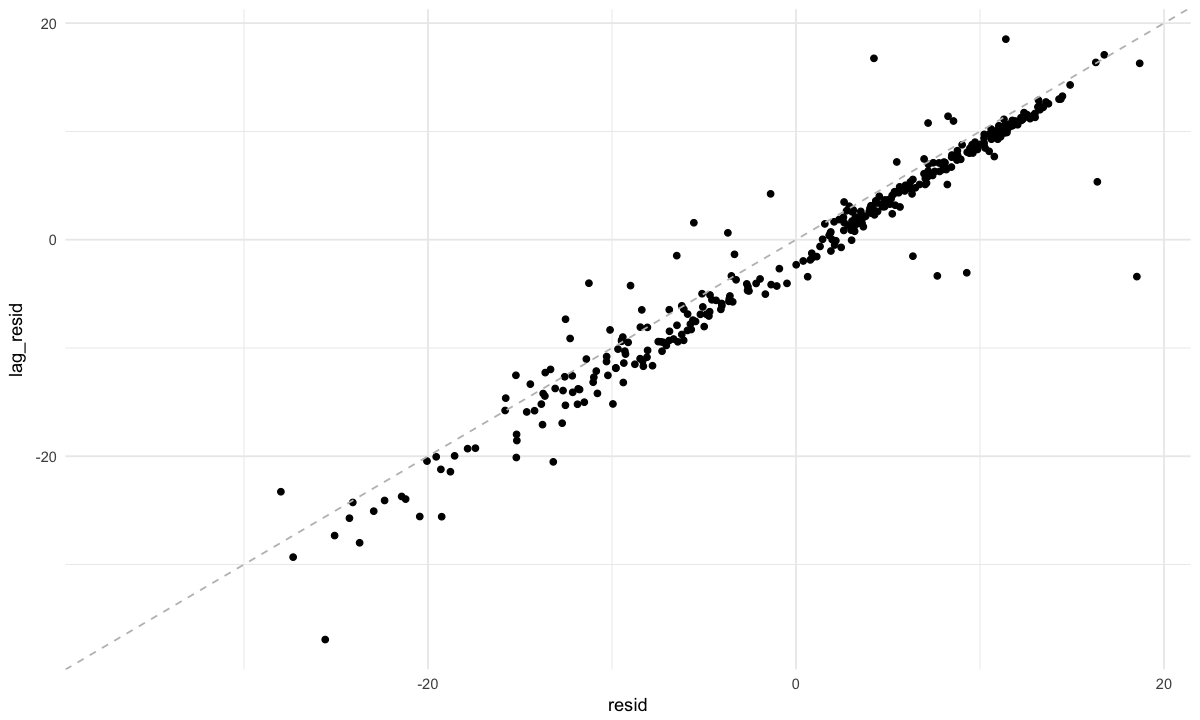

In [33]:
hiv_gap %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
            mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
            geom_abline(slope = 1, linetype = "dashed", colour = "grey")

The linear model assumes that the residuals are *uncorrelated*, whereas here the correlation between each residual and its lag is close to 1. There are a few ways to address this. One is to look at the first-differences model:

In [34]:
hiv_gap_2 = gapminder %>% mutate(year = make_date(year)) %>% left_join(hiv) %>% 
    arrange(country, year) %>% mutate(dlife = c(NA, diff(lifeExp)))
mod = lm(dlife ~ hiv_pct, hiv_gap_2)
mod %>% summary

Joining, by = c("country", "year")
Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


Call:
lm(formula = dlife ~ hiv_pct, data = hiv_gap_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.4101  -0.5790  -0.1276   0.6275  12.2501 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.57571    0.09228   17.08   <2e-16 ***
hiv_pct     -0.31111    0.01869  -16.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.841 on 480 degrees of freedom
  (1222 observations deleted due to missingness)
Multiple R-squared:  0.3659,	Adjusted R-squared:  0.3645 
F-statistic: 276.9 on 1 and 480 DF,  p-value: < 2.2e-16


The interpretation of this regression is now different. It says that a one point increase in the HIV percentage causes the 5-year change in life expectancy to decrease by -.31 years.

If we again compare residuals, they look much more like random noise:

Warning message:
“Removed 1348 rows containing missing values (geom_point).”

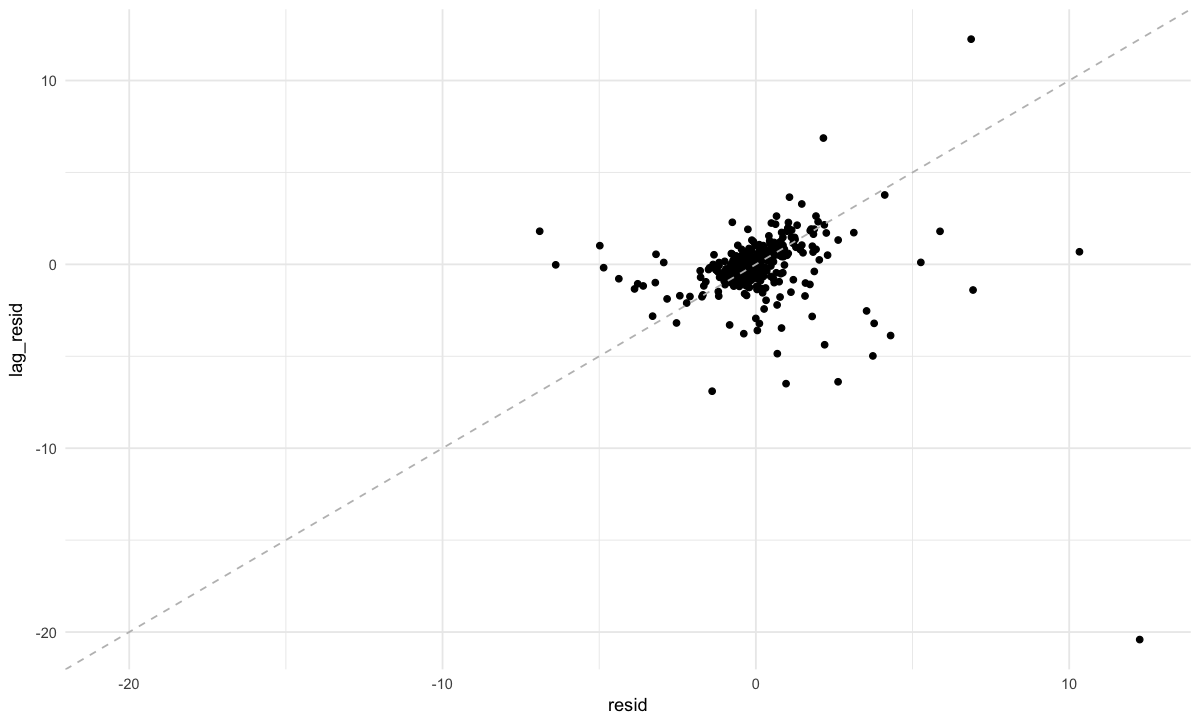

In [35]:
hiv_gap_2 %>% add_residuals(mod) %>% group_by(country) %>% arrange(country, year) %>% 
              mutate(lag_resid = lag(resid)) %>% ggplot(aes(resid, lag_resid)) + geom_point() + 
              geom_abline(slope = 1, linetype = "dashed", colour = "grey")

### Logistic regression -- analysis of cancer data
Let us now return to an example we saw several lectures back when we looked at cancer expression data:

In [5]:
load('../lecture18/gcm14.RData')

This dataset has a huge number of predictors:

In [64]:
dim(gcm14)

[1]   190 11131

To deal with this, we will use a logistic regression model that also does *feature selection*.

In [65]:
library(glmnet)

We split the data into two groups, training and test, to assess how well our classifier does on a held-out set of data:

In [68]:
dfs <- split(gcm14, gcm14$split)

Now we fit our model. This is essentially the logistic regression procedure that we saw earlier. However, the method incorporates a "penalty" that makes it choose only a small number of predictors:

In [69]:
X <- as.matrix(dfs$train[,-c(1, 2)])
mdl <- cv.glmnet(y = dfs$train$class == 9, x = X, 
                 family = "binomial", type.measure = "class")

Let's see how we did on the test set:

In [71]:
X <- as.matrix(dfs$test[,-c(1, 2)])
predict(mdl, newx = X, type="class") %>% as.logical %>% tibble(dfs$test$class == 9, pred = .)

   dfs$test$class == 9 pred 
1  FALSE               FALSE
2  FALSE               FALSE
3  FALSE               FALSE
4  FALSE               FALSE
5  FALSE               FALSE
6  FALSE               FALSE
7  FALSE               FALSE
8  FALSE               FALSE
9  FALSE               FALSE
10 FALSE               FALSE
11 FALSE               FALSE
12 FALSE               FALSE
13 FALSE               FALSE
14 FALSE               FALSE
15 FALSE               FALSE
16 FALSE               FALSE
17 FALSE               FALSE
18 FALSE               FALSE
19 FALSE               FALSE
20 FALSE               FALSE
21 FALSE               FALSE
22 FALSE               FALSE
23 FALSE               FALSE
24 FALSE               FALSE
25  TRUE                TRUE
26  TRUE                TRUE
27  TRUE                TRUE
28  TRUE               FALSE
29  TRUE                TRUE
30  TRUE                TRUE
31 FALSE               FALSE
32 FALSE               FALSE
33 FALSE               FALSE
34 FALSE      

(Five out of six.)

What do our heatmaps look like?

In [110]:
M <- coef(mdl) %>% as.matrix 
feats <- rownames(M)[M != 0][-1]

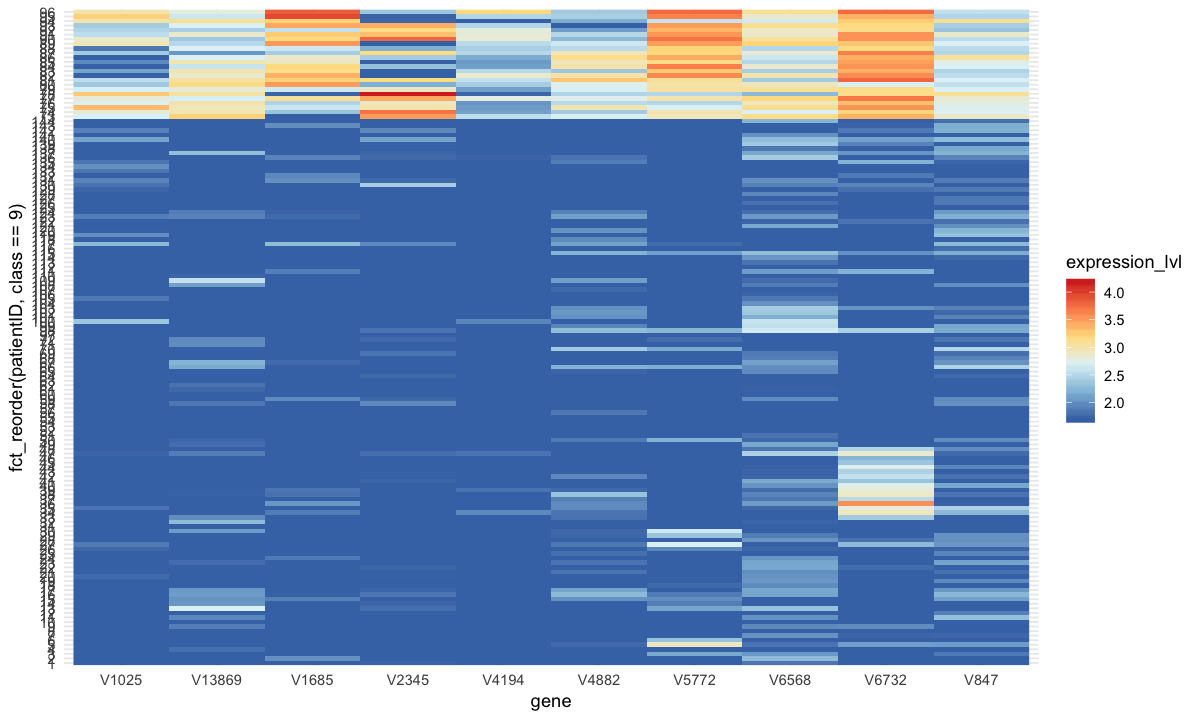

In [195]:
dfs$train %>% select(c("class", feats)) %>% 
    mutate(patientID = factor(row_number())) %>% 
    gather(key = gene, value = expression_lvl, -class, -patientID) %>% 
    ggplot + geom_raster(aes(x = gene, y = fct_reorder(patientID, class == 9), fill = expression_lvl)) +
    scale_fill_distiller(palette = "RdYlBu")